In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from sklearn.gaussian_process.kernels import PairwiseKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from numpy.random import rand, randn

In [2]:
df = pd.read_csv("data/onethousand/Curated/GSD/ExpressionData.csv")
df = df.set_index("Unnamed: 0").T
X = df.values

# small data (n=1000) exploration

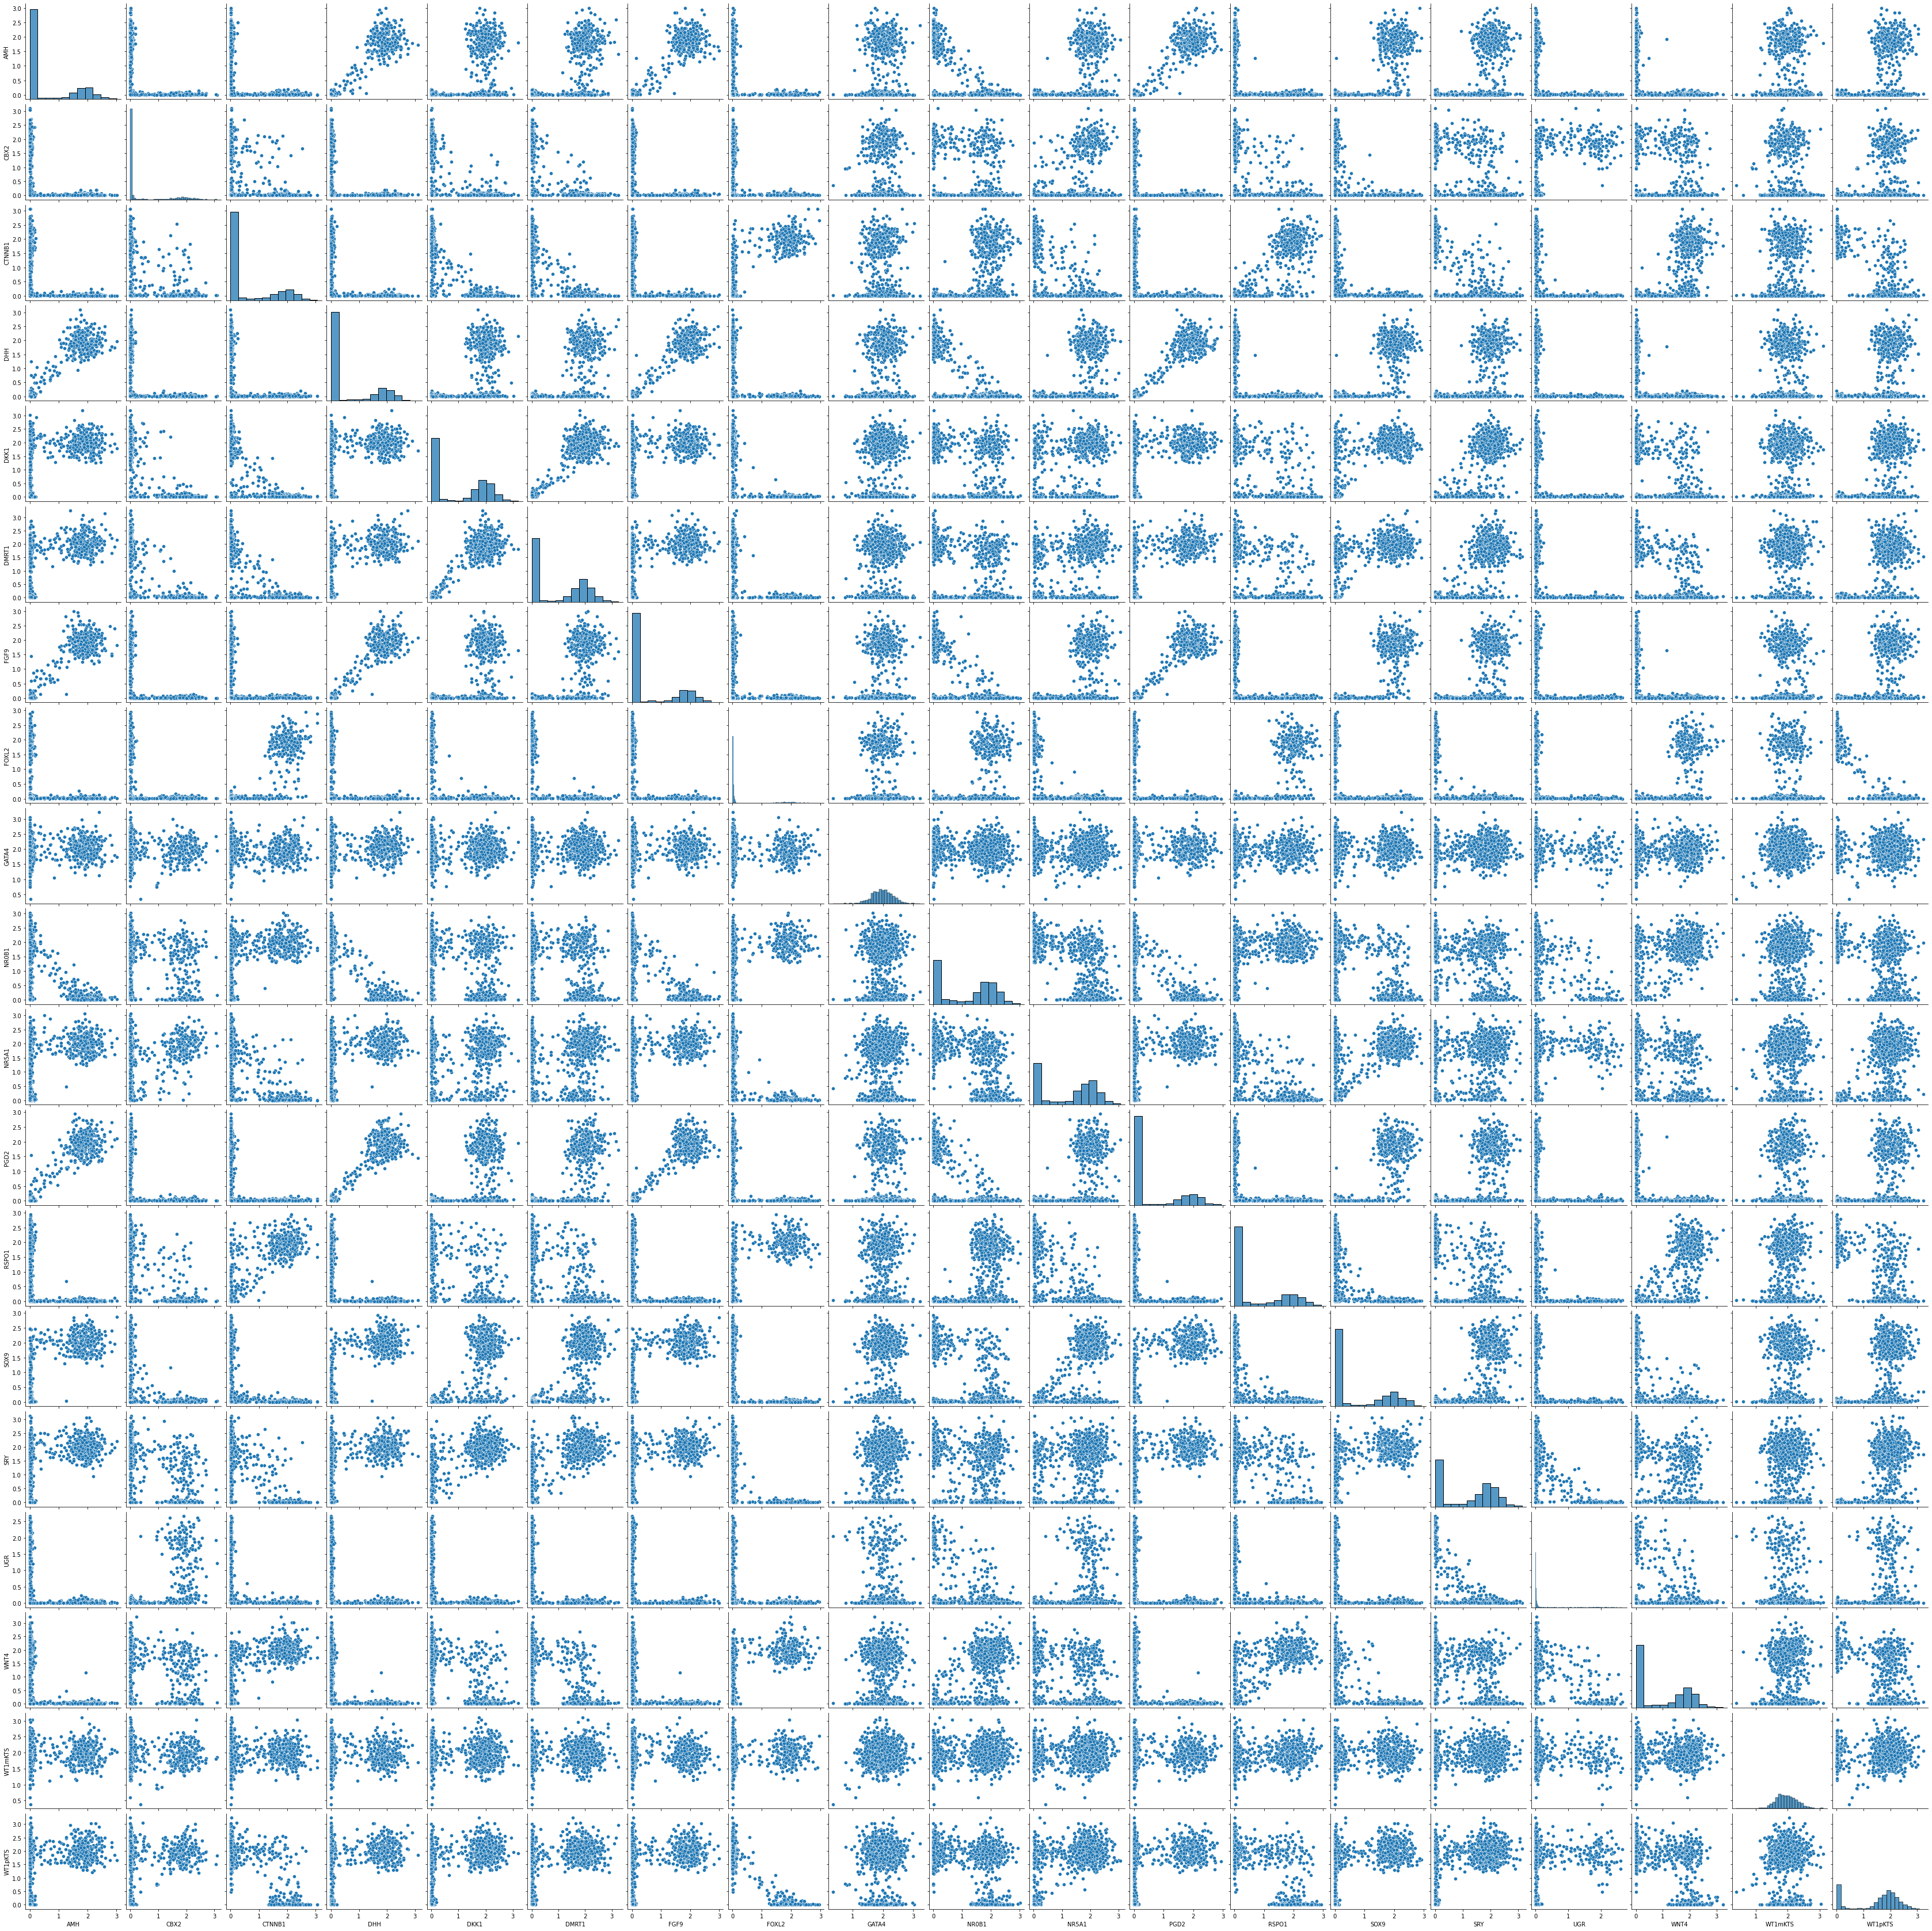

In [3]:
sns.pairplot(df);

# Hilbert Schmidt Independence Criterion

Following 

Gretton, A., Fukumizu, K., Teo, C. H., Song, L., Schölkopf, B., & Smola, A. J. (2007, January). A kernel statistical test of independence. In Nips (Vol. 20, pp. 585-592).

https://pure.mpg.de/rest/items/item_1791468/component/file_3009860/content

In [4]:
def distance(a, b):
    # euclidean distance (a - b)**2 = a**2 - 2ab + b**2
    asq = np.sum(a**2, -1, keepdims=True)
    bsq = np.sum(b**2, -1, keepdims=True)
    return asq - 2 * a @ b.T + bsq.T

def hsic(a, b, sigma=0.1):
    n, _ = a.shape
    K = np.exp(-distance(a, a) * a.var())
    L = np.exp(-distance(b, b) * b.var())
    H = np.eye(n) - 1.0 / n * np.ones((n, n))
    traced = np.trace(L @ H @ K @ H)
    Z = ((n - 1) ** 2)
    return traced / Z

In [5]:
xx = randn(1000)[:, None]
yy = randn(1000)[:, None]
hsic(xx, xx), hsic(xx, yy)

(0.09592714428060502, 0.00028112900808472546)

  0%|          | 0/171 [00:00<?, ?it/s]

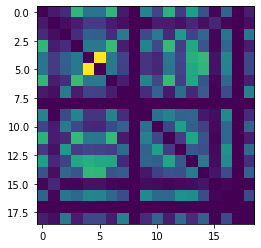

In [6]:
# test all pairs
n, d = X.shape
G = np.zeros((d, d))
pairs = [(i, j) for i in range(d) for j in range(i)]
for i, j in tqdm(pairs):
    pair = (X[:, i, None], X[:, j, None])
    score = hsic(*pair)
    G[i, j] = score
G = G + G.T
plt.imshow(G)

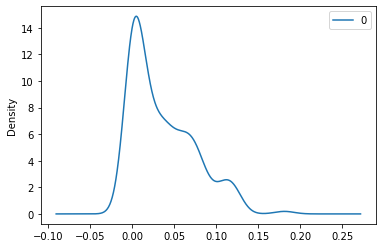

In [7]:
# need to define a cut off
pd.DataFrame(G.flatten()).plot.kde();

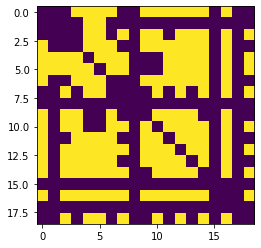

In [8]:
plt.imshow(G>0.03);

# for more samples (n>1000) we need an approximation

this section follows

Zhang, Qinyi, et al. "Large-scale kernel methods for independence testing." Statistics and Computing 28.1 (2018): 113-130.
APA, https://link.springer.com/content/pdf/10.1007/s11222-016-9721-7.pdf

the random feature method was derived by 


Rahimi, Ali, and Benjamin Recht. "Random Features for Large-Scale Kernel Machines." NIPS. Vol. 3. No. 4. 2007.
APA	, https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.145.8736&rep=rep1&type=pdf




With the addition, that we automatically set the kernel length scale according to the data variance. This is a common practice found in popular implementation of kernel methods such as in scikit-learn.

In [9]:
class RandomFeature:
    def __init__(self, dim, sigma=None):
        self.dim = dim
        self.sigma = sigma
        self.omega = None
        self.tau = None
        
    def fit(self, X):
        n, d = X.shape
        if self.sigma is None:
            self.sigma = 1 / X.var()
        self.omega = randn(d, self.dim)
        self.tau = 2 * np.pi * rand(1, self.dim)
        
    def transform(self, X):
        feat = np.cos(X @ self.omega * self.sigma + self.tau)
        return np.sqrt(2 / self.dim) * feat
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

def hsic_rf(a, b, sigma=None):
    n, _ = a.shape
    ff = RandomFeature(dim=1024, sigma=sigma)
    za = ff.fit_transform(a)
    zb = ff.fit_transform(b)
    H = np.eye(n) - 1.0 / n * np.ones((n, n))
    gencov = 1/n * za.T @ H @ zb
    return np.sum(gencov ** 2)

In [10]:
xx = randn(10000)[:, None]
yy = randn(10000)[:, None]

In [11]:
hsic_rf(xx, xx), hsic_rf(xx, yy)

(0.07112647095258, 7.95806707974818e-06)

# (verification) infer graph again

In [13]:
n, d = X.shape
G_plus = np.zeros((d, d))
pairs = [(i, j) for i in range(d) for j in range(i)]
for i, j in tqdm(pairs):
    pair = (X[:, i, None], X[:, j, None])
    score = hsic_rf(*pair)
    G_plus[i, j] = score
G_plus = G_plus + G_plus.T

  0%|          | 0/171 [00:00<?, ?it/s]

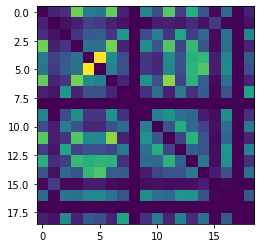

In [14]:
plt.imshow(G_plus)

# how close is it to the original implementation?

In [15]:
# explained variance
1 - (G - G_plus).var() / G.var()

0.9844767061493649

# now do the same on big data (n=10_000)

In [16]:
df = pd.read_csv("data/tenthousand/Curated/GSD/ExpressionData.csv")
df = df.set_index("Unnamed: 0").T
X = df.values

In [18]:
n, d = X.shape
G_plus = np.zeros((d, d))
pairs = [(i, j) for i in range(d) for j in range(i)]
for i, j in tqdm(pairs):
    pair = (X[:, i, None], X[:, j, None])
    score = hsic_rf(*pair)
    G_plus[i, j] = score
G_plus = G_plus + G_plus.T

  0%|          | 0/171 [00:00<?, ?it/s]

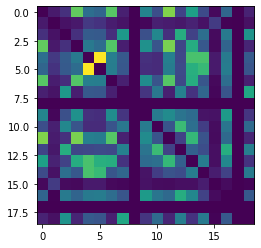

In [19]:
plt.imshow(G_plus)

tbd - to be discussed

How does independence based skeleton inference deal with interaction information? Consider the XOR problem, where observing x1, or x2 
individually exhibits no mutual information with the the classification target. The independence test would falsely reject the edge.